In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from glob import glob
import utils
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wasserstein_distance
import multiprocessing_function
import pickle
from sklearn.manifold import MDS, TSNE, Isomap, LocallyLinearEmbedding, spectral_embedding
from sklearn.neighbors import NearestNeighbors


In [2]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [3]:
sub_ids = 4,
label_type = 'task'
all_files = []

for sub_id in sub_ids:
    files = glob(f'./sub{sub_id}_raw_{label_type}/*.mat')

    all_files.extend(files)
all_files.sort()
len(all_files), all_files

(4,
 ['./sub4_raw_task/times_micro2.mat',
  './sub4_raw_task/times_micro3.mat',
  './sub4_raw_task/times_micro4.mat',
  './sub4_raw_task/times_micro5.mat'])

In [4]:
stimulus_start = 3.617371458000000e+06 - 1000 # converted to ms units
stimulus_end = 4283174.909 + 1000 #3928953.551 + 3520

In [5]:
spikes_all = []
yticks = []
event_times_labeled = scipy.io.loadmat('./events/sub4_macro_events.mat')
events = np.load('./events/label_cor.npy')

min_spike_time = np.exp(200)

for f in all_files:
    mat = scipy.io.loadmat(f)['cluster_class']
    idx = np.where(mat[:, 0] > 0)[0]
    spikes = mat[idx, 1]
    
    idx = np.where((spikes >= stimulus_start) & (spikes < stimulus_end))
    spikes = spikes[idx]
    
    min_spike_time = min(spikes[0], min_spike_time)

    
for f in all_files:
    mat = scipy.io.loadmat(f)['cluster_class']
    idx = np.where(mat[:, 0] > 0)[0]
    spikes = mat[idx, 1]
    
    idx = np.where((spikes >= stimulus_start) & (spikes < stimulus_end))
    spikes = spikes[idx]
    
    normalized = spikes - min_spike_time
    spikes_all.append(normalized)
    print(normalized[-1])
    
    channel = f.split('/')[-1].split('_')[-1].split('.')[0][-1]
    yticks.append(channel)
    


667132.6695000003
664829.0454999995
665130.5767499995
666921.7945000003


In [6]:
event_times = event_times_labeled['Eve'][:, 1] / 1000
event_times_normalized = (event_times - min_spike_time)/1000
diff = event_times_labeled['Eve'][1:,1] - event_times_labeled['Eve'][:-1,1]
idx = np.where(diff > 3600000)
rest_start_idx = idx[0][1]
rest_end_idx = idx[0][1]+1

rest_start = event_times[idx[0][1]]-min_spike_time
rest_end = event_times[idx[0][1]+1]-min_spike_time
print(rest_start, rest_end)

316432.4982499997 350430.0782499998


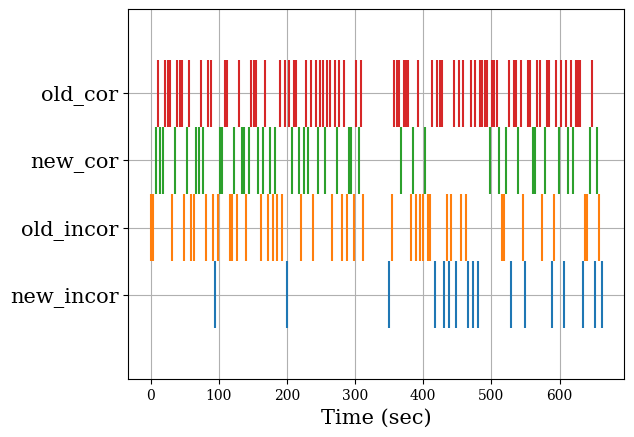

In [7]:
event_times_mat = np.asarray([(event_times_labeled['new_incor'].reshape(-1,)/1000-min_spike_time)/1000, 
                           (event_times_labeled['old_incor'].reshape(-1,)/1000-min_spike_time)/1000,
                           (event_times_labeled['new_cor'].reshape(-1,)/1000-min_spike_time)/1000,
                           (event_times_labeled['old_cor'].reshape(-1,)/1000-min_spike_time)/1000], dtype=object)
colors1 = ['C{}'.format(i) for i in range(4)]
plt.eventplot(event_times_mat, colors=colors1)

#plt.legend( ['new_incor', 'old_incor', 'new_cor', 'old_cor'], bbox_to_anchor=(1.4, 0.75), fontsize=15)
# plt.plot([event_times_normalized[rest_start_idx], event_times_normalized[rest_start_idx]], 
#              [-1, 4],'r--')
# plt.plot([event_times_normalized[rest_end_idx], event_times_normalized[rest_end_idx]], 
#              [-1, 4],'r--')
plt.xlabel('Time (sec)', fontsize=15)
plt.yticks([0,1,2,3],['new_incor', 'old_incor', 'new_cor', 'old_cor'], fontsize=15)
plt.grid()

In [8]:
event_times_normalized_labeled = {}
event_times_normalized_labeled['new_incor'] = (event_times_labeled['new_incor'].reshape(-1,)/1000-min_spike_time)/1000 
event_times_normalized_labeled['old_incor'] = (event_times_labeled['old_incor'].reshape(-1,)/1000-min_spike_time)/1000
event_times_normalized_labeled['new_cor'] = (event_times_labeled['new_cor'].reshape(-1,)/1000-min_spike_time)/1000
event_times_normalized_labeled['old_cor'] = (event_times_labeled['old_cor'].reshape(-1,)/1000-min_spike_time)/1000

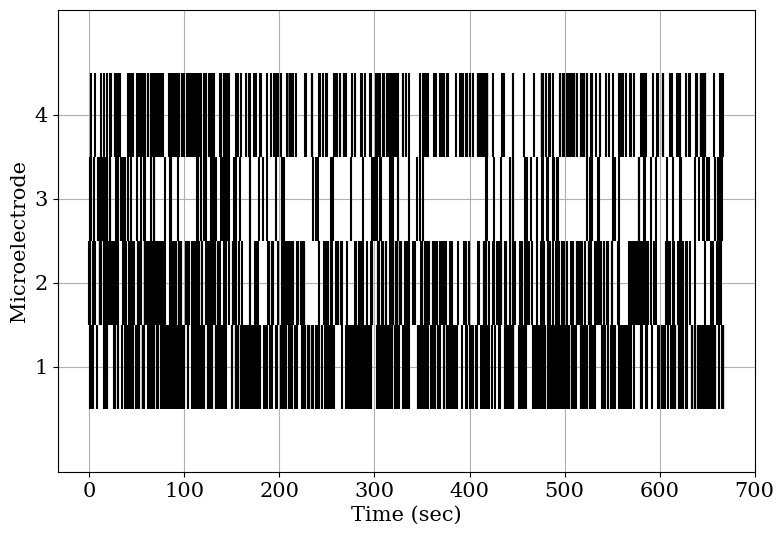

In [9]:
xticks = np.arange(8) * 100000 #np.arange(5) * 50000
plt.figure(figsize=(9,6))
plt.eventplot(spikes_all, color='black')

# plt.plot([event_times_normalized[rest_start_idx]*1000, event_times_normalized[rest_start_idx]*1000], 
#              [-1, 4],'r--')
# plt.plot([event_times_normalized[rest_end_idx]*1000, event_times_normalized[rest_end_idx]*1000], 
#              [-1, 4],'r--')

plt.xticks(xticks, xticks//1000, fontsize=15)
# plt.yticks(np.arange(4), yticks, fontsize=15)
plt.yticks(np.arange(4), ['1', '2', '3', '4'], fontsize=15)
plt.xlabel('Time (sec)', fontsize=15)
plt.ylabel('Microelectrode', fontsize=15)
plt.grid()
plt.show()

Text(0.02, 0.5, 'Firing rate (spikes/sec)')

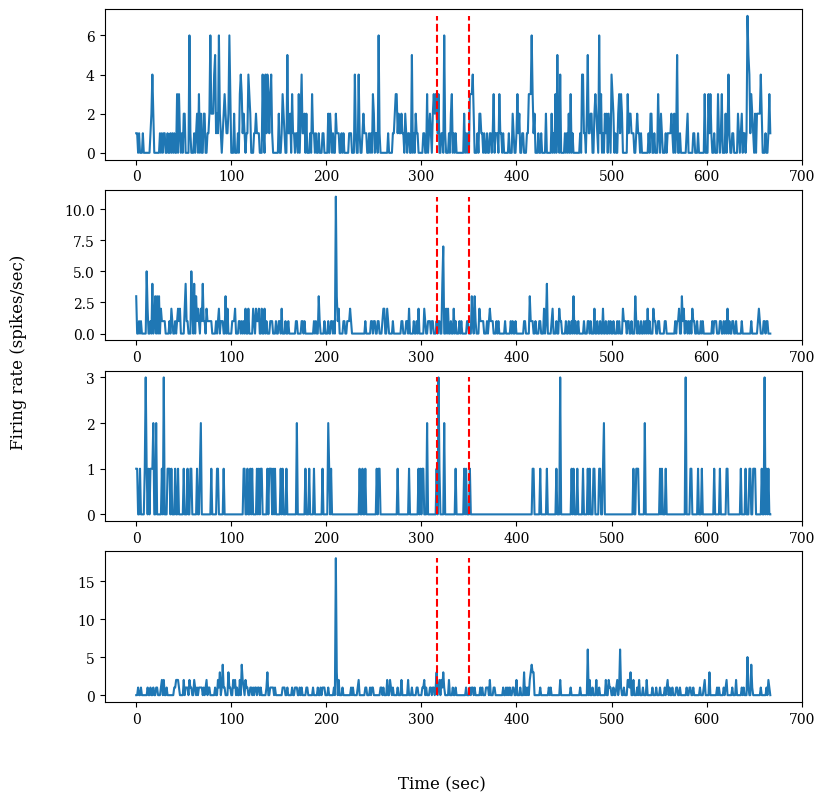

In [10]:
hists = []
for i in range(len(spikes_all)):
    hist, bin_edges = np.histogram(spikes_all[i], bins=np.arange(669)*1000)
    hists.append(hist)
    
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9,9))
for i in range(len(spikes_all)):
    axes[i].plot(hists[i])
    
    
    axes[i].plot([event_times_normalized[rest_start_idx], event_times_normalized[rest_start_idx]], 
                 [0, np.max(hists[i])],'r--')
    axes[i].plot([event_times_normalized[rest_end_idx], event_times_normalized[rest_end_idx]], 
                 [0, np.max(hists[i])],'r--')
fig.supxlabel('Time (sec)')
fig.supylabel('Firing rate (spikes/sec)')

Text(0.02, 0.5, 'Smoothed firing rate (spikes/6sec)')

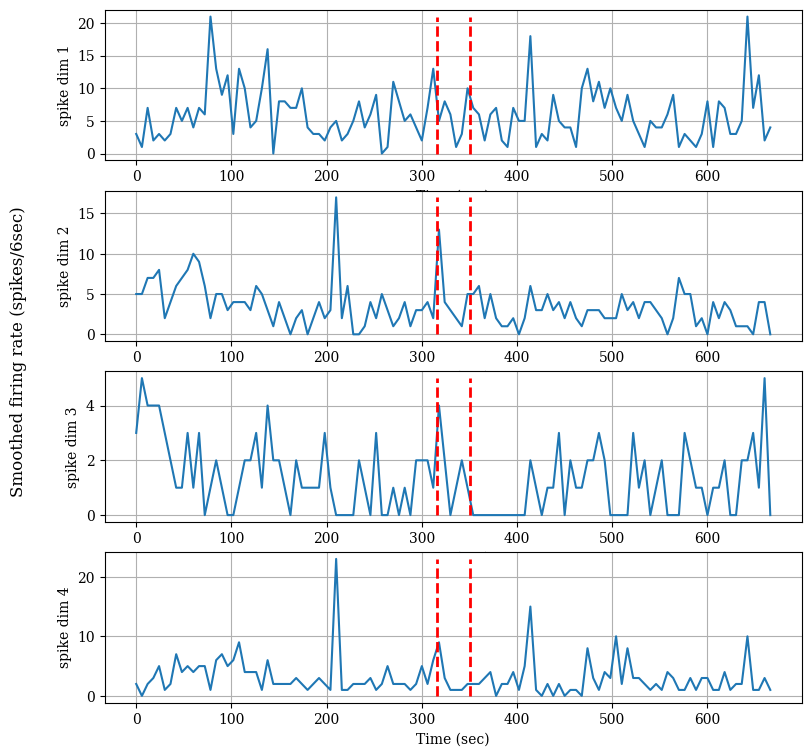

In [11]:
hists2 = []
for i in range(len(spikes_all)):
    hist2, bin_edges = np.histogram(spikes_all[i]/1000, bins=np.arange(678)[::6])
    hists2.append(hist2)
xx = np.arange(672)[::6]    
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(9,9))

peak_idx = [69, 53, 35]
#peak_idx = [82]
colors = ['k--', 'g--', 'm--', 'c--']*3

for i in range(len(spikes_all)):
    axes[i].plot(xx, hists2[i])
    axes[i].grid()
    
    axes[i].plot([event_times_normalized[rest_start_idx], event_times_normalized[rest_start_idx]], 
                 [0, np.max(hists2[i])],'r--', lw=2)
    axes[i].plot([event_times_normalized[rest_end_idx], event_times_normalized[rest_end_idx]], 
                 [0, np.max(hists2[i])],'r--', lw=2)
    axes[i].set_ylabel(f'spike dim {i+1}')
    axes[i].set_xlabel('Time (sec)')
#fig.supxlabel('Time (sec)')
fig.supylabel('Smoothed firing rate (spikes/6sec)')

In [12]:
def visualize_3d_embeddings(embeddings, text_indices, drawline=False):
    first, second, third = 0,1,2
    fig = plt.figure(figsize=(5,5))
    axis = fig.add_subplot(projection = '3d')

    colors = 'blue', 'orange'

    axis.scatter(embeddings[:, first], embeddings[:, second], embeddings[:, third], s=11 ,color=colors[0], alpha=0.7)
    if drawline:
        axis.plot(embeddings[:, first], embeddings[:, second], embeddings[:, third], alpha=0.6)
    # for i in range(0,edge,5):
    #     axis.text(embeddings[i, first], embeddings[i, second], embeddings[i, third], f'{i}', fontsize=12, color='red', alpha=0.6)

    # axis.set_xticks(ticks)
    # axis.set_yticks(ticks)
    # axis.set_zticks(ticks)

    for i in text_indices:
        axis.text(embeddings[i, first], embeddings[i, second], embeddings[i, third], f'{i}', 
                  fontsize=10, color='red', alpha=0.8)

    
    # show the plot

    axis.xaxis._axinfo["grid"]['linewidth'] = .8
    axis.yaxis._axinfo["grid"]['linewidth'] = .8
    axis.zaxis._axinfo["grid"]['linewidth'] = .8

    # axis.xaxis._axinfo["grid"]['alpha'] = .1
    # axis.yaxis._axinfo["grid"]['alpha'] = .8
    # axis.zaxis._axinfo["grid"]['alpha'] = .8

    axis.xaxis._axinfo["grid"]['linestyle'] = ":"
    axis.yaxis._axinfo["grid"]['linestyle'] = ":"
    axis.zaxis._axinfo["grid"]['linestyle'] = ":"

    # axis.set_xticklabels([])
    # axis.set_yticklabels([])
    # axis.set_zticklabels([])

    axis.set_xlabel("Axis 1")
    axis.set_ylabel("Axis 2")
    axis.set_zlabel("Axis 3")
    #axis.view_init(azim=60)
    #axis.view_init(elev=60, azim=0)
    # plt.savefig('./fig_embed_wasser.pdf', format='pdf', bbox_inches="tight", dpi=300)
    
def get_connectivity(embeddings, nn_distances, nn_indices, num_nns = 10, num_pairs = 100):
    rows = np.empty(0)
    cols = np.empty(0)
    dists = np.empty(0)
    for i in range(len(embeddings)):
        idx = np.where(np.abs(nn_indices[i, :num_nns] - i)>10)
        cur_dists = nn_distances[i, :num_nns][idx]
        cur_indices = nn_indices[i, :num_nns][idx]
        rows = np.hstack([rows, np.array([i]*len(cur_dists))])
        cols = np.hstack([cols, cur_indices])
        dists = np.hstack([dists, cur_dists])
    nn_rows = rows[np.argsort(dists)[:num_pairs]]
    nn_cols = cols[np.argsort(dists)[:num_pairs]]
    
    return nn_rows, nn_cols
    
def visualize_2d_embeddings(embeddings, text_indices, first, second, colors=None, t=1, drawline=False, 
                            nn_rows=None, nn_cols=None):    
    plt.figure(figsize=(8,8))
    sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.6)
    plt.colorbar(sc)
    
    # for i in range(0,len(embeddings),2):
    #     plt.text(embeddings[i, first], embeddings[i, second], f'{t*i}', fontsize=15, color='red', alpha=0.5)

    # draw connectivity
    if nn_rows is not None and nn_cols is not None:
        for r, c in zip(nn_rows, nn_cols):
            r = int(r)
            c = int(c)
            plt.plot([embeddings[r, first], embeddings[c, first]], 
                     [embeddings[r, second], embeddings[c, second]], 'k', alpha=0.1, zorder=-1)
    if drawline:
        plt.plot(embeddings[:, first], embeddings[:, second], alpha=0.1)
    
    for j, t in enumerate(text_indices):
        plt.text(embeddings[j, first], embeddings[j, second], t, fontsize=10, color='blue', alpha=0.5)

    plt.show()

In [13]:
import numpy.linalg as la
def myMDS(distmat, dim):
    # square it
    A = distmat**2

    # centering matrix
    n = A.shape[0]
    J_c = 1./n*(np.eye(n) - 1 + (n-1)*np.eye(n))

    # perform double centering
    B = -0.5*(J_c.dot(A)).dot(J_c)
    B = 0.5*(B+B.T)

    # find eigenvalues and eigenvectors
    eigen_val, eigen_vec = la.eigh(B)
    idx = np.argsort(eigen_val)[::-1]
    eigen_val = eigen_val[idx]
    eigen_vec = eigen_vec[:,idx]
    # select top 2 dimensions (for example)
    return eigen_vec[:,:dim]*np.sqrt(eigen_val[:dim]), eigen_vec, eigen_val

In [14]:
def count_labels(data, end_time, window, slide):
    # count labels by sliding window...
    window_list = []
    start_idx = 0
    while(start_idx + window <= end_time):
        window_list.append(np.sum(np.logical_and(data >= start_idx, data < start_idx+window)))
        start_idx += slide
    return np.array(window_list)

def count_labels2(data, window_start_times, window):
    # count labels from specified window_start_times for given window...
    window_list = []
    for window_start in window_start_times:
        window_list.append(np.sum(np.logical_and(data >= window_start, data < window_start+window)))
    return np.array(window_list)

def get_count_labels_hist(event_times_normalized_labeled, w, t, window_start_times=None, plot=False):
    # units for w, t: sec
    label_traj = {}
    if window_start_times is None:
        window_start_times = [i*t for i in range(int((668-w-1)/t)+1)]
    for key in event_times_normalized_labeled.keys():
        label_traj[key] = count_labels2(event_times_normalized_labeled[key], 
                                         window_start_times, w)

    label_traj['x'] = window_start_times[:len(label_traj[key])]
    label_traj['all'] = label_traj['old_cor']+label_traj['old_incor']+label_traj['new_cor']+label_traj['new_incor']

    label_traj['old'] = label_traj['old_cor']+label_traj['old_incor']
    label_traj['new'] = label_traj['new_cor']+label_traj['new_incor']
    label_traj['ans_old']  =  label_traj['old_cor']+label_traj['new_incor']
    label_traj['ans_new']  =  label_traj['old_incor']+label_traj['new_cor']
    label_traj['cor'] = label_traj['old_cor']+label_traj['new_cor']
    label_traj['incor'] = label_traj['old_incor']+label_traj['new_incor']
    
    label_traj['rc_new'] = label_traj['new_cor']/label_traj['new']
    label_traj['rc_old'] = label_traj['old_cor']/label_traj['old']
    label_traj['pr_new'] = label_traj['new_cor']/label_traj['ans_new']
    label_traj['pr_old'] = label_traj['old_cor']/label_traj['ans_old']
    
    label_traj['old_rate'] = label_traj['old']/label_traj['all']
    label_traj['new_rate'] = label_traj['new']/label_traj['all']
    label_traj['ans_old_rate']  =  label_traj['ans_old']/label_traj['all']
    label_traj['ans_new_rate']  =  label_traj['ans_new']/label_traj['all']
    label_traj['cor_rate'] = label_traj['cor']/label_traj['all']
    label_traj['incor_rate'] = label_traj['incor']/label_traj['all']
    
    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11,3))

        axes.plot(label_traj['x'], label_traj['pr_new'], label='precision_new')
        axes.plot(label_traj['x'], label_traj['pr_old'], label='precision_old')
        axes.plot(label_traj['x'], label_traj['rc_new'], label='recall_new')
        axes.plot(label_traj['x'], label_traj['rc_old'], label='recall_old')
        axes.legend(bbox_to_anchor=(1.0, 1.0), fontsize=15)
        # axes[1].set_xticks([i*10 for i in range(10)])
        axes.set_ylim([0, 1.1])
        axes.grid()

        axes.set_ylabel(f'Average performance \n within {w}sec window', fontsize=15)
        axes.set_xlabel(f'{w}sec-window start time (sec)', fontsize=15)
    return label_traj

def draw_labels_hist(label_traj, w, t, timeindices, color='g', keys = ['pr_new', 'pr_old', 'rc_new', 'rc_old']):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11,3))
    for key in keys:
        axes.plot(label_traj['x'], label_traj[key], label=key)
    axes.legend(bbox_to_anchor=(1.0, 1.0), fontsize=15)
    for i in timeindices:
        axes.plot([i*t, i*t], [0, 1], color+'--', alpha=0.5)
    # axes[1].set_xticks([i*10 for i in range(10)])
    # axes.set_ylim([0, 1.1])
    axes.grid()
    
    axes.set_ylabel(f'Average performance \n within {w}sec window', fontsize=15)
    axes.set_xlabel(f'{w}sec-window start time (sec)', fontsize=15)

In [15]:
spikes_all_1 = []
spikes_all_2 = []
for i in range(len(spikes_all)):
    spikes_all_1.append(spikes_all[i][spikes_all[i]<event_times_normalized[90]*1000])
    spikes_all_2.append(spikes_all[i][spikes_all[i]>=event_times_normalized[91]*1000])

In [16]:
for i in range(4):
    print(len(spikes_all_1[i]), len(spikes_all_2[i]))

326 312
210 150
80 55
181 146


In [17]:
def get_spike_timing_data(spikes_all, window, slide, end_time):
    X = []
    start_time = 0.0
    while(start_time + window <= end_time):

        w = []
        for s in spikes_all:
            idx = np.where((s >= start_time) & (s < start_time + window))[0]
            w.append(s[idx])
        X.append(w)
        start_time += slide

    X = np.asarray(X, dtype=object)
    X_new = X
    X_new.shape
    n = X_new.shape[0]

    for i in range(X.shape[0]):
        for j in range(4):
            if len(X[i,j]) == 0:
                print(i,j)
    return X_new

def get_pairwise_distance_between_matched(X_new, window=3500, use_L2=False):
    n = X_new.shape[0]
    pd = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i >= j:
                continue
            for k in range(X_new.shape[1]):
                if use_L2:
                    if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                        pd[i, j] += window**2
                    else:
                        pd[i, j] += \
                        multiprocessing_function.time_wasserstein(X_new[i, k], X_new[j, k], skip_none=False)**2
                else:
                    if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                        pd[i, j] += window
                    else:
                        pd[i, j] += \
                        multiprocessing_function.time_wasserstein(X_new[i, k], X_new[j, k], skip_none=False)
                
            if use_L2:
                pd[i, j] = np.sqrt(pd[i, j])
    pd = (pd + pd.T)
    return pd

def get_pairwise_distance(X_new, slide, window=1, match_start_time=True, use_L2=False):
    n = X_new.shape[0]
    pd = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i >= j:
                continue

            for k in range(X_new.shape[1]):
                if match_start_time:
                    if use_L2:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window**2
                        else:
                            pd[i, j] += multiprocessing_function.time_wasserstein(X_new[i, k], X_new[j, k]-(j-i)*slide, skip_none=False)**2
                    else:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window
                        else:
                            pd[i, j] += multiprocessing_function.time_wasserstein(X_new[i, k], X_new[j, k]-(j-i)*slide, skip_none=False)
                else:
                    if use_L2:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += (window+(j-i)*slide)**2
                        else:
                            pd[i, j] += multiprocessing_function.time_wasserstein(X_new[i, k], X_new[j, k], skip_none=False)**2
                    else:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window+(j-i)*slide
                        else:
                            pd[i, j] += multiprocessing_function.time_wasserstein(X_new[i, k], X_new[j, k], skip_none=False)
                #pd[i, j] += multiprocessing_function.aligned_distance(X_new[i, k], X_new[j, k])
                # if k != 2:
            if use_L2:
                pd[i, j] = np.sqrt(pd[i, j])
    pd = (pd + pd.T)
    return pd

In [18]:
def visualize_2d_embeddings_multiple(embeddings, label_traj, keys, first, second, 
                                     line_indices = [], drawline=False, ncols=3):   
    k = 0
    nrows = (len(keys)-1)//ncols + 1
    for i in range(nrows):
        fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, figsize=(12,6))
        for l in range(ncols):
            if k < len(keys):
                colors = label_traj[keys[k]]
                sc = axes[l].scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.6)
                fig.colorbar(sc)

                if drawline:
                    axes[l].plot(embeddings[:, first], embeddings[:, second], alpha=0.3)
                for line_index in line_indices:
                    axes[l].plot(embeddings[line_index, first], embeddings[line_index, second], 'r', alpha=0.5)
                axes[l].set_title(keys[k])
                k += 1
    
    plt.show()

In [19]:
def convert_to_text(values):
    return [f'{v:.2f}' for v in values]

In [20]:
def vp_distance(tli, tlj, cost):
    """
    Calculates the "spike time" distance (Victor & Purpura 1996) for a single cost.
    
    Parameters:
    tli : list or numpy array
        Vector of spike times for the first spike train.
    tlj : list or numpy array
        Vector of spike times for the second spike train.
    cost : float
        Cost per unit time to move a spike.
        
    Returns:
    float
        The spike time distance between the two spike trains.
    """
    nspi = len(tli)
    nspj = len(tlj)

    if cost == 0:
        return abs(nspi - nspj)
    elif cost == np.inf:
        return nspi + nspj

    scr = np.zeros((nspi + 1, nspj + 1))
    
    # Initialize margins with cost of adding a spike
    scr[:, 0] = np.arange(nspi + 1)
    scr[0, :] = np.arange(nspj + 1)

    if nspi and nspj:
        for i in range(1, nspi + 1):
            for j in range(1, nspj + 1):
                scr[i, j] = min(
                    scr[i-1, j] + 1, 
                    scr[i, j-1] + 1, 
                    scr[i-1, j-1] + cost * abs(tli[i-1] - tlj[j-1])
                )

    return scr[nspi, nspj]

def get_pairwise_vp_distance(X_new, slide, cost, window=1, match_start_time=True, use_L2=False):
    n = X_new.shape[0]
    pd = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i >= j:
                continue

            for k in range(X_new.shape[1]):
                if match_start_time:
                    if use_L2:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window**2
                        else:
                            pd[i, j] += vp_distance(X_new[i, k], X_new[j, k]-(j-i)*slide, cost)**2
                    else:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window
                        else:
                            pd[i, j] += vp_distance(X_new[i, k], X_new[j, k]-(j-i)*slide, cost)
                else:
                    if use_L2:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += (window+(j-i)*slide)**2
                        else:
                            pd[i, j] += vp_distance(X_new[i, k], X_new[j, k], cost)**2
                    else:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window+(j-i)*slide
                        else:
                            pd[i, j] += vp_distance(X_new[i, k], X_new[j, k], cost)
                #pd[i, j] += multiprocessing_function.aligned_distance(X_new[i, k], X_new[j, k])
                # if k != 2:
            if use_L2:
                pd[i, j] = np.sqrt(pd[i, j])
    pd = (pd + pd.T)
    return pd


def vp_distance_multicost(tli, tlj, costs):
    """
    Calculates the "spike time" distance (Victor & Purpura 1996) for a single cost.
    
    Parameters:
    tli : list or numpy array
        Vector of spike times for the first spike train.
    tlj : list or numpy array
        Vector of spike times for the second spike train.
    cost : list or numpy array
        Cost per unit time to move a spike.
        
    Returns:
    float
        The spike time distance between the two spike trains.
    """
    nspi = len(tli)
    nspj = len(tlj)

    if costs == 0:
        return abs(nspi - nspj)
    elif costs == np.inf:
        return nspi + nspj

    costs = np.array(costs)
    scr = np.zeros((len(costs), nspi + 1, nspj + 1))
    
    # Initialize margins with cost of adding a spike
    scr[:, :, 0] = np.tile(np.arange(nspi + 1), (len(costs), 1))
    scr[:, 0, :] = np.tile(np.arange(nspj + 1), (len(costs), 1))

    if nspi and nspj:
        for i in range(1, nspi + 1):
            for j in range(1, nspj + 1):
                scr[:, i, j] = np.min(
                    np.vstack([scr[:, i-1, j] + 1, 
                    scr[:, i, j-1] + 1, 
                    scr[:, i-1, j-1] + costs * abs(tli[i-1] - tlj[j-1])]), axis=0
                )

    return scr[:, nspi, nspj]

# Example usage:
tli = [0.1, 0.4, 0.6]
tlj = [0.15, 0.5]
cost = 1.0

distance = vp_distance(tli, tlj, cost)
print("Spike Time Distance:", distance)


tli = [0.4218,    0.7922,    0.9157,    0.9595]
tlj = [0.0357,    0.6557,    0.6787,    0.7577,    0.8491,    0.9340]
cost = 10
distance = vp_distance(tli, tlj, 100)
distance

Spike Time Distance: 1.15


9.830000000000009

In [21]:
def laplace_kernel_distance(tli, tlj, tau):
    def laplace_kernel(tli, tlj, tau):
        diff = tli.reshape(-1,1) - tlj.reshape(1,-1)
        return np.sum(np.exp(-np.abs(diff)/tau))

    return np.sqrt(laplace_kernel(tli, tli, tau) - 2*laplace_kernel(tli, tlj, tau) + laplace_kernel(tlj, tlj, tau))

def get_pairwise_laplace_kernel_distance(X_new, slide, tau, window=1, match_start_time=True, use_L2=False):
    n = X_new.shape[0]
    pd = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i >= j:
                continue

            for k in range(X_new.shape[1]):
                if match_start_time:
                    if use_L2:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window**2
                        else:
                            pd[i, j] += laplace_kernel_distance(X_new[i, k], X_new[j, k]-(j-i)*slide, tau)**2
                    else:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window
                        else:
                            pd[i, j] += laplace_kernel_distance(X_new[i, k], X_new[j, k]-(j-i)*slide, tau)
                else:
                    if use_L2:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += (window+(j-i)*slide)**2
                        else:
                            pd[i, j] += laplace_kernel_distance(X_new[i, k], X_new[j, k], tau)**2
                    else:
                        if len(X_new[i,k]) == 0 or len(X_new[j,k]) == 0:
                            pd[i, j] += window+(j-i)*slide
                        else:
                            pd[i, j] += laplace_kernel_distance(X_new[i, k], X_new[j, k], tau)
                
            if use_L2:
                pd[i, j] = np.sqrt(pd[i, j])
    pd = (pd + pd.T)
    return pd

## Comparison with spike counting measure

In [22]:
window=140000
slide=3500
end_time = stimulus_end - min_spike_time
X_ = []
for s in spikes_all:
    windowed = utils.window_spikes(s, end_time=int(end_time), window=window, slide=slide, absoulte=False, binary=True)
    X_.append(windowed)
X_ = np.asarray(X_)
print(X_.shape)
X_new_ = np.transpose(X_, (1,0,2))
X_new_ = np.sum(X_new_, axis=-1)

(4, 151, 140000)


In [23]:
n_neighbors = 10
n_components = 3
mds_ = Isomap(n_neighbors=n_neighbors, n_components=n_components)
embeddings_ = mds_.fit_transform(X_new_)

nbrs_ = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(embeddings_[:,:3])
distances_, indices_ = nbrs_.kneighbors(embeddings_[:,:3])
nn_rows_, nn_cols_=get_connectivity(embeddings_, distances_, indices_, num_nns = 10, num_pairs = 100)


In [24]:
w=140000
t=3500
label_traj = get_count_labels_hist(event_times_normalized_labeled, w/1000, t/1000)

## Comparison with spike counting histogram

In [25]:
window=140000
slide=3500
binsize = 3500
X_ = []
for s in spikes_all:
    windowed = utils.window_spikes(s, end_time=int(end_time), window=window, slide=slide, absoulte=False, binary=True)
    X_.append(windowed)
X_ = np.asarray(X_)
print(X_.shape)
X_new_ = np.transpose(X_, (1,0,2))
X_new_ = X_new_.reshape(X_.shape[1], X_.shape[0], window//binsize, binsize).sum(axis=-1).reshape(X_.shape[1], -1)

(4, 151, 140000)


In [26]:
n_neighbors = 10
n_components = 3
mds_ = Isomap(n_neighbors=n_neighbors, n_components=n_components)
embeddings_2 = mds_.fit_transform(X_new_)

nbrs_ = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(embeddings_2[:,:3])
distances_, indices_ = nbrs_.kneighbors(embeddings_2[:,:3])
nn_rows_, nn_cols_=get_connectivity(embeddings_2, distances_, indices_, num_nns = 10, num_pairs = 100)


### Pairwise L2 distance and MDS (match initial time)

In [27]:
window = 140000 # 30000
slide = 3500 # 2000
end_time = stimulus_end - min_spike_time
use_L2 = True
match_start_time = True
X_new = get_spike_timing_data(spikes_all, window, slide, end_time)
pd1_L2_match = get_pairwise_distance(X_new, slide, window=window, match_start_time=match_start_time, use_L2=use_L2)

In [28]:
n_neighbors = 10
n_components = 3
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_L2_match1 = mds.fit_transform(pd1_L2_match)
print(mds.kernel_pca_.eigenvalues_)

[9.54512749e+10 6.66054058e+10 4.74749351e+10]


In [29]:
nbrs3 = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(embeddings_L2_match1[:,:3])
distances3, indices3 = nbrs3.kneighbors(embeddings_L2_match1[:,:3])
nn_rows, nn_cols=get_connectivity(embeddings_L2_match1, distances3, indices3, num_nns = 10, num_pairs = 20)


In [30]:
nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(embeddings_L2_match1[:,:2])
distances, indices = nbrs.kneighbors(embeddings_L2_match1[:,:2])

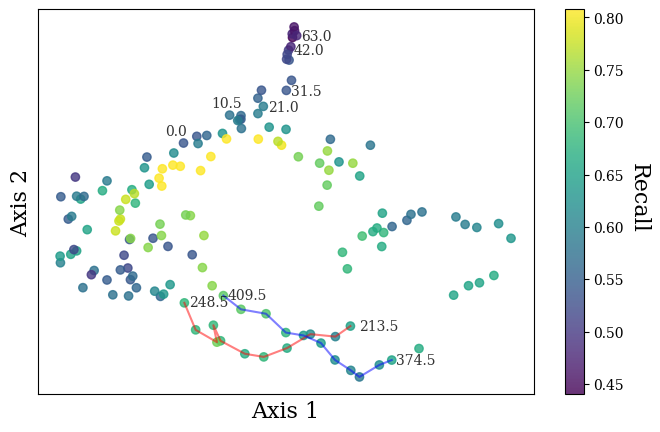

In [31]:
first, second = 0, 1
embeddings = embeddings_L2_match1
colors = label_traj['rc_old']
plt.figure(figsize=(8,5))
sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.8)
cbar = plt.colorbar(sc)
# cbar.set_label('Recall', rotation=270, fontsize=16, labelpad=2)
ax = cbar.ax
ax.text(3.3,0.6,'Recall',rotation=270, fontsize=16)


line_indices = [[i for i in range(61, 72)], [i for i in range(107, 118)]]
color_set = ['r', 'b']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5)    

    
text_indices = [60, 61, 66, 67]
# t=60
# plt.text(embeddings[t, first]+1000, embeddings[t, second]-4000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=61
plt.text(embeddings[t, first]+2000, embeddings[t, second]-1000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=66
# plt.text(embeddings[t, first]+1000, embeddings[t, second]-4000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=67
# plt.text(embeddings[t, first]+1000, embeddings[t, second]-1000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=71
plt.text(embeddings[t, first]+1000, embeddings[t, second]-1000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=107
plt.text(embeddings[t, first]+1000, embeddings[t, second]-1000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=117
plt.text(embeddings[t, first]+1000, embeddings[t, second]-1000, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
line_indices = [[60, 61], [66, 67]]

# plt.scatter(embeddings[66:68, first], embeddings[66:68, second], alpha=1)
# color_set = ['k--', 'k--']
# for i, line_index in enumerate(line_indices):
#     plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5) 


scales=1000
steps = [0, 3]
for step in steps:
    plt.text(embeddings[step, first]-4*scales, embeddings[step, second]+2*scales, f'{step*3.5}', fontsize=10, color='k', alpha=0.8)
steps = [6, 9, 12, 18]
for step in steps:
    plt.text(embeddings[step, first]+1*scales, embeddings[step, second]-1.2*scales, f'{step*3.5}', fontsize=10, color='k', alpha=0.8)


plt.xticks([])
plt.yticks([])    
plt.grid()
plt.xlabel('Axis 1', fontsize=16)
plt.ylabel('Axis 2', fontsize=16)
# plt.savefig(f'./spike_embedding_Wass.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

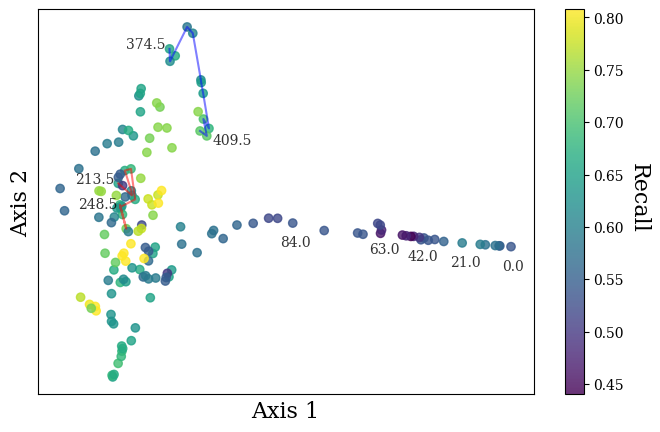

In [32]:
embeddings = embeddings_
colors = label_traj['rc_old']
plt.figure(figsize=(8,5))
sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.8)
cbar = plt.colorbar(sc)
# cbar.set_label('Recall', rotation=270, fontsize=16, labelpad=2)
ax = cbar.ax
ax.text(3.3,0.6,'Recall',rotation=270, fontsize=16)


line_indices = [[i for i in range(61, 72)], [i for i in range(107, 118)]]
color_set = ['r', 'b']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5)    

    
text_indices = [60, 61, 66, 67]
# t=60
# plt.text(embeddings[t, first]+3, embeddings[t, second], f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=61
plt.text(embeddings[t, first]-14, embeddings[t, second], f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=66
# plt.text(embeddings[t, first]+3, embeddings[t, second], f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=67
# plt.text(embeddings[t, first]+2, embeddings[t, second]-1, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=71
plt.text(embeddings[t, first]-14, embeddings[t, second], f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=107
plt.text(embeddings[t, first]-14, embeddings[t, second], f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=117
plt.text(embeddings[t, first]+4, embeddings[t, second]-2, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# line_indices = [[60, 61], [66, 67]]
# color_set = ['k--', 'k--']
# for i, line_index in enumerate(line_indices):
#     plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5) 


scales=1
steps = [0]
for step in steps:
    plt.text(embeddings[step, first]-3*scales, embeddings[step, second]-3.5*scales, f'{step*3.5}', fontsize=10, color='k', alpha=0.8)
steps = [6, 12, 18, 24]
for step in steps:
    plt.text(embeddings[step, first]-4*scales, embeddings[step, second]-3.5*scales, f'{step*3.5}', fontsize=10, color='k', alpha=0.8)
    

plt.xticks([])
plt.yticks([])    
plt.grid()
plt.xlabel('Axis 1', fontsize=16)
plt.ylabel('Axis 2', fontsize=16)
# plt.savefig(f'./spike_embedding_counting.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

## Comparison with Victor-Purpura distance

In [33]:
window = 140000 # 30000
slide = 3500 # 2000
end_time = stimulus_end - min_spike_time
use_L2 = True
match_start_time = True
X_new = get_spike_timing_data(spikes_all, window, slide, end_time)



In [34]:
# pd1_vp_L2_match_set = []
# costs = [0, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1]
# for cost in costs:
#     print("calculating cost: {:f}".format(cost))
#     pd1_vp_L2_match = get_pairwise_vp_distance(X_new, slide, cost, window=window, match_start_time=match_start_time, use_L2=use_L2)
#     pd1_vp_L2_match_set.append(pd1_vp_L2_match)

# import pickle
# filename = './pairwise_distance_vp.pickle'
# res_vp = {}
# res_vp['costs'] = costs
# res_vp['pairwise_distances'] = pd1_vp_L2_match_set
# with open(filename, 'wb') as handle:
#     pickle.dump(res_vp, handle, protocol=pickle.HIGHEST_PROTOCOL)

calculating cost: 0.000000
calculating cost: 0.000010
calculating cost: 0.000100
calculating cost: 0.001000
calculating cost: 0.010000
calculating cost: 0.100000
calculating cost: 1.000000


In [64]:
filename = './pairwise_distance_vp.pickle'
with open(filename, 'rb') as f:
    res_vp = pickle.load(f)
costs = res_vp['costs']
pd1_vp_L2_match_set = res_vp['pairwise_distances']

Text(0.5, 1.0, 'VP distance cost = 0.000100')

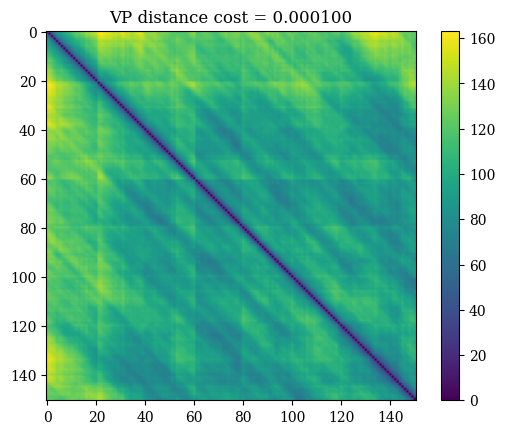

In [35]:
idx=2
plt.imshow(pd1_vp_L2_match_set[idx])
plt.colorbar()
plt.title("VP distance cost = {:f}".format(costs[idx]))

In [36]:
n_neighbors = 10
n_components = 5
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_vp_L2_match1 = mds.fit_transform(pd1_vp_L2_match_set[idx])
print(mds.kernel_pca_.eigenvalues_)

[2067872.02381387 1080922.20051899  729322.5647097   373701.0200433
  304201.05201755]


Text(0.5, 1.0, 'Adjacency (cost: 0.000100)')

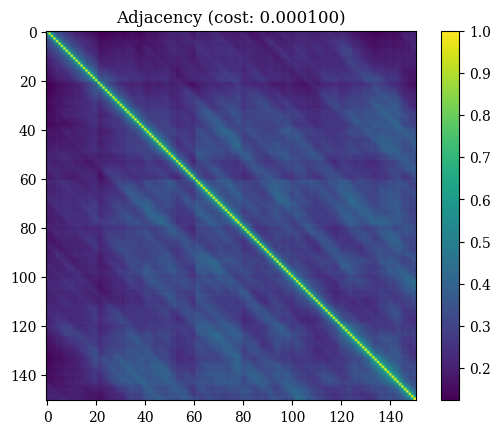

In [37]:
temp = np.sort(pd1_vp_L2_match_set[idx], axis=1)
h = np.mean(temp, axis=0)
adjacency1 = np.exp(-pd1_vp_L2_match_set[idx]/h[10])
plt.imshow(adjacency1)
plt.colorbar()
embeddings_vp_L2_match1_spectral = spectral_embedding(adjacency=adjacency1, n_components=3, norm_laplacian=True) 
plt.title('Adjacency (cost: {:f})'.format(costs[idx]))

[2067872.02381387 1080922.20051899  729322.5647097   373701.0200433
  304201.05201755]


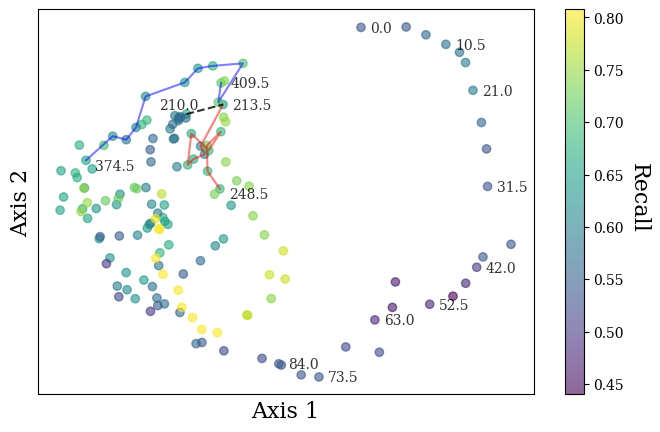

In [38]:
## for rebuttal PDF
idx=2
n_neighbors = 10
n_components = 5
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_vp_L2_match1 = mds.fit_transform(pd1_vp_L2_match_set[idx])
print(mds.kernel_pca_.eigenvalues_)


first, second = 0, 1
embeddings = embeddings_vp_L2_match1
# embeddings = embeddings_vp_L2_match1_spectral
colors = label_traj['rc_old']
plt.figure(figsize=(8,5))
sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.6)
cbar = plt.colorbar(sc)
# cbar.set_label('Recall', rotation=270, fontsize=16, labelpad=2)
ax = cbar.ax
ax.text(3.3,0.6,'Recall',rotation=270, fontsize=16)
# plt.plot(embeddings[:, first], embeddings[:, second], 'g', alpha=0.3)


line_indices = [[i for i in range(61, 72)], [i for i in range(107, 118)]]
# line_indices = [[i for i in range(31, 60)], [i for i in range(61, 90)], [i for i in range(91, 120)]]
# line_indices = [[i for i in range(45, 50)], [i for i in range(78, 83)]]
# line_indices = [[i for i in range(60, 65)], [i for i in range(90, 95)]]
# line_indices = [[i for i in range(51, 60)], [i for i in range(105, 114)], [i for i in range(90, 96)]]
color_set = ['r', 'b', 'm']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5)    

    
text_indices = [60, 61, 66, 67]
scales = 10
t=60
plt.text(embeddings[t, first]-3*scales, embeddings[t, second]+0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=61
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=66
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-4*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=67
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=71
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=107
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=117
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)

line_indices = [[60, 61]]#, [66, 67]]
color_set = ['k--', 'k--']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.8) 

scales=10
for t in range(9):
    plt.text(embeddings[3*t, first]+1*scales, embeddings[3*t, second]-0.5*scales, f'{3*3.5*t}', fontsize=10, color='k', alpha=0.8)
    
# plt.title('VP embedding cost={:.0e}'.format(costs[idx]))
plt.xticks([])
plt.yticks([])    
# plt.xlim([-0.01, 0.005])
# plt.ylim([-0.01, 0.01])
plt.grid()
plt.xlabel('Axis 1', fontsize=16)
plt.ylabel('Axis 2', fontsize=16)
# plt.savefig(f'./spike_embedding_VP1e-4.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

[617885.21274439  90861.51225798  44620.57347535  38359.07280712
  14265.44785881]


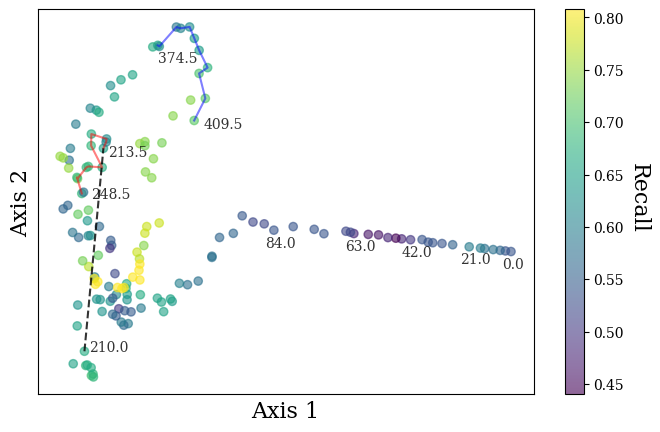

In [39]:
## for rebuttal PDF
idx=1
n_neighbors = 10
n_components = 5
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_vp_L2_match1 = mds.fit_transform(pd1_vp_L2_match_set[idx])
print(mds.kernel_pca_.eigenvalues_)


first, second = 0, 1
embeddings = embeddings_vp_L2_match1
# embeddings = embeddings_vp_L2_match1_spectral
colors = label_traj['rc_old']
plt.figure(figsize=(8,5))
sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.6)
cbar = plt.colorbar(sc)
# cbar.set_label('Recall', rotation=270, fontsize=16, labelpad=2)
ax = cbar.ax
ax.text(3.3,0.6,'Recall',rotation=270, fontsize=16)
# plt.plot(embeddings[:, first], embeddings[:, second], 'g', alpha=0.3)


line_indices = [[i for i in range(61, 72)], [i for i in range(107, 118)]]
# line_indices = [[i for i in range(31, 60)], [i for i in range(61, 90)], [i for i in range(91, 120)]]
# line_indices = [[i for i in range(45, 50)], [i for i in range(78, 83)]]
# line_indices = [[i for i in range(60, 65)], [i for i in range(90, 95)]]
# line_indices = [[i for i in range(51, 60)], [i for i in range(105, 114)], [i for i in range(90, 96)]]
color_set = ['r', 'b', 'm']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5)    

    
text_indices = [60, 61, 66, 67]
scales = 5
t=60
plt.text(embeddings[t, first]+0.5*scales, embeddings[t, second]+0.0*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=61
plt.text(embeddings[t, first]+0.5*scales, embeddings[t, second]-0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=66
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-4*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=67
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=71
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-0.3*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=107
plt.text(embeddings[t, first]+0*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=117
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)

line_indices = [[60, 61]]#, [66, 67]]
color_set = ['k--', 'k--']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.8) 

scales=10
steps=6
for t in range(5):
    
    plt.text(embeddings[steps*t, first]-0.5*scales, embeddings[steps*t, second]-0.5*scales, f'{steps*3.5*t}', fontsize=10, color='k', alpha=0.8)
    
# plt.title('VP embedding cost={:.0e}'.format(costs[idx]))
plt.xticks([])
plt.yticks([])    
# plt.xlim([-0.01, 0.005])
# plt.ylim([-0.01, 0.01])
plt.grid()
plt.xlabel('Axis 1', fontsize=16)
plt.ylabel('Axis 2', fontsize=16)
# plt.savefig(f'./spike_embedding_VP1e-5.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

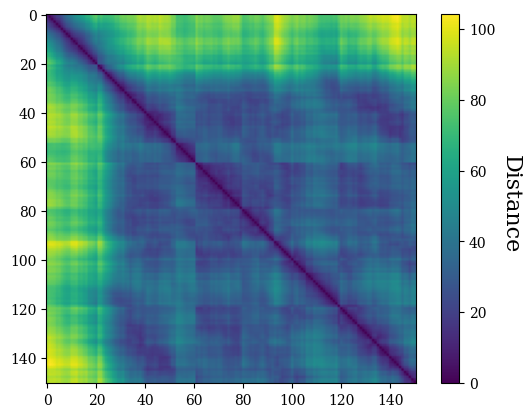

In [40]:
## for rebuttal PDF
idx=1
plt.imshow(pd1_vp_L2_match_set[idx])
plt.colorbar()
# ax = cbar.ax
plt.text(185,95,'Distance',rotation=270, fontsize=16)
# plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))
# plt.savefig(f'./pairwise_dist_VP1e-5.pdf', format='pdf', bbox_inches="tight", dpi=300)

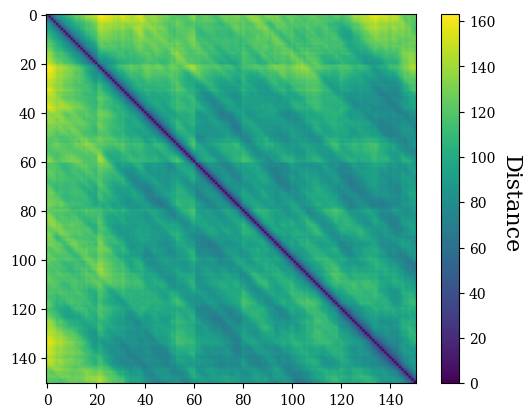

In [41]:
## for rebuttal PDF
idx=2
plt.imshow(pd1_vp_L2_match_set[idx])
plt.colorbar()
# ax = cbar.ax
plt.text(185,95,'Distance',rotation=270, fontsize=16)
# plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))
# plt.savefig(f'./pairwise_dist_VP1e-4.pdf', format='pdf', bbox_inches="tight", dpi=300)

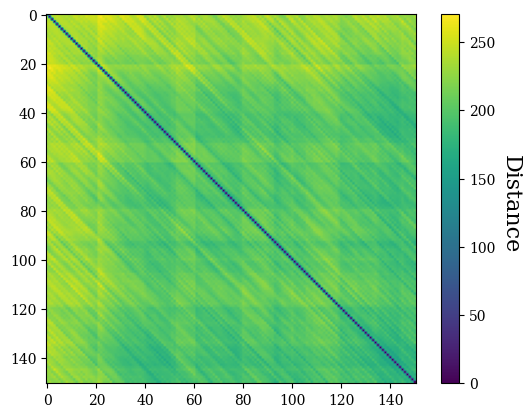

In [42]:
## for rebuttal PDF
idx=3
plt.imshow(pd1_vp_L2_match_set[idx])
plt.colorbar()
# ax = cbar.ax
plt.text(185,95,'Distance',rotation=270, fontsize=16)
# plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))
# plt.savefig(f'./pairwise_dist_VP1e-3.pdf', format='pdf', bbox_inches="tight", dpi=300)

## Comparison with kernel distance measure

In [43]:
window = 140000 # 30000
slide = 3500 # 2000
end_time = stimulus_end - min_spike_time
use_L2 = True
match_start_time = True
X_new = get_spike_timing_data(spikes_all, window, slide, end_time)



In [44]:
# pd1_lk_L2_match_set = []
# taus = [1, 10, 100, 1000, 10000, 100000, 1e6]
# for tau in taus:
#     print("calculating tau: {:f}".format(tau))
#     pd1_lk_L2_match = get_pairwise_laplace_kernel_distance(X_new, slide, tau, window=window, match_start_time=match_start_time, use_L2=use_L2)
#     pd1_lk_L2_match_set.append(pd1_lk_L2_match)

calculating tau: 1.000000
calculating tau: 10.000000
calculating tau: 100.000000
calculating tau: 1000.000000
calculating tau: 10000.000000
calculating tau: 100000.000000
calculating tau: 1000000.000000


In [45]:
# taus = [1e7, 1e8, 1e9]
# for tau in taus:
#     print("calculating tau: {:f}".format(tau))
#     pd1_lk_L2_match = get_pairwise_laplace_kernel_distance(X_new, slide, tau, window=window, match_start_time=match_start_time, use_L2=use_L2)
#     pd1_lk_L2_match_set.append(pd1_lk_L2_match)

calculating tau: 10000000.000000
calculating tau: 100000000.000000
calculating tau: 1000000000.000000


In [46]:
# taus = [1, 10, 100, 1000, 10000, 100000, 1e6, 1e7, 1e8, 1e9]

In [58]:
# import pickle
# filename = './pairwise_distance_lk.pickle'
# res_lk = {}
# res_lk['taus'] = taus
# res_lk['pairwise_distances'] = pd1_lk_L2_match_set
# with open(filename, 'wb') as handle:
#     pickle.dump(res_lk, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
filename = './pairwise_distance_lk.pickle'
with open(filename, 'rb') as f:
    res_lk = pickle.load(f)
taus = res_lk['taus']
pd1_lk_L2_match_set = res_lk['pairwise_distances']

Text(0.5, 1.0, 'Laplace kernel distance tau = 1000.0')

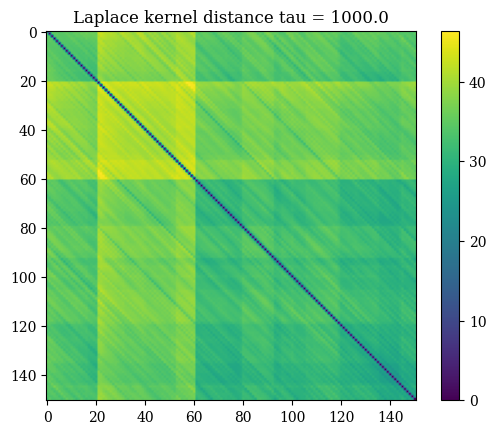

In [47]:
idx=3
plt.imshow(pd1_lk_L2_match_set[idx])
plt.colorbar()
plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))

In [48]:
n_neighbors = 10
n_components = 5
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_lk_L2_match1 = mds.fit_transform(pd1_lk_L2_match_set[idx])
print(mds.kernel_pca_.eigenvalues_)

[30112.9108988  22721.0058954  19809.03758134 19135.89150117
 16259.89645483]


Text(0.5, 1.0, 'Adjacency (cost: 1000.0)')

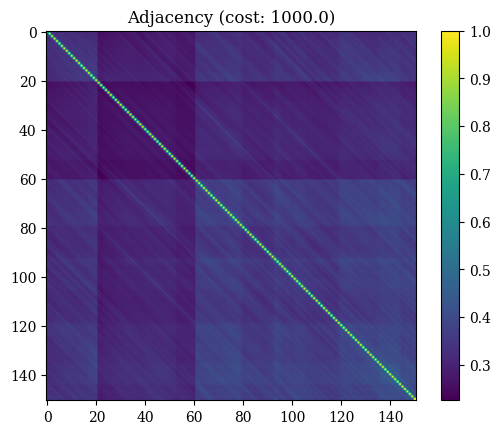

In [49]:
temp = np.sort(pd1_lk_L2_match_set[idx], axis=1)
h = np.mean(temp, axis=0)
adjacency1 = np.exp(-pd1_lk_L2_match_set[idx]/h[10])
embeddings_lk_L2_match1_spectral = spectral_embedding(adjacency=adjacency1, n_components=3, norm_laplacian=True) 
plt.imshow(adjacency1)
plt.colorbar()
plt.title('Adjacency (cost: {:.1f})'.format(taus[idx]))

[309071.33160378 186467.94189454 102326.5954926   62600.71432878
  49755.59995398]


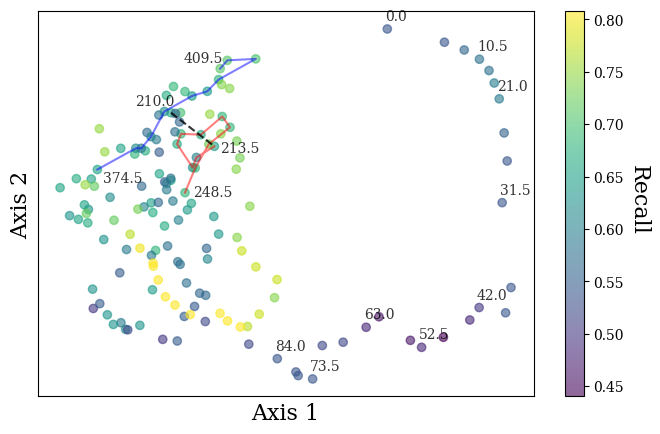

In [50]:
## for rebuttal PDF
idx=4
n_neighbors = 10
n_components = 5
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_lk_L2_match1 = mds.fit_transform(pd1_lk_L2_match_set[idx])
print(mds.kernel_pca_.eigenvalues_)


first, second = 0, 1
embeddings = embeddings_lk_L2_match1
# embeddings = embeddings_lk_L2_match1_spectral
colors = label_traj['rc_old']
plt.figure(figsize=(8,5))
sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.6)
cbar = plt.colorbar(sc)
# cbar.set_label('Recall', rotation=270, fontsize=16, labelpad=2)
ax = cbar.ax
ax.text(3.3,0.6,'Recall',rotation=270, fontsize=16)
# plt.plot(embeddings[:, first], embeddings[:, second], 'g', alpha=0.3)


line_indices = [[i for i in range(61, 72)], [i for i in range(107, 118)]]
# line_indices = [[i for i in range(31, 60)], [i for i in range(61, 90)], [i for i in range(91, 120)]]
# line_indices = [[i for i in range(45, 50)], [i for i in range(78, 83)]]
# line_indices = [[i for i in range(60, 65)], [i for i in range(90, 95)]]
# line_indices = [[i for i in range(51, 60)], [i for i in range(105, 114)], [i for i in range(90, 96)]]
color_set = ['r', 'b', 'm']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5)    

    
text_indices = [60, 61, 66, 67]
scales = 5
t=60
plt.text(embeddings[t, first]-3.0*scales, embeddings[t, second]+0.6*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=61
plt.text(embeddings[t, first]+0.5*scales, embeddings[t, second]-0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=66
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-4*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=67
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=71
plt.text(embeddings[t, first]+0.7*scales, embeddings[t, second]-0.3*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=107
plt.text(embeddings[t, first]+0.5*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=117
plt.text(embeddings[t, first]-3*scales, embeddings[t, second]+0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)

line_indices = [[60, 61]]#, [66, 67]]
color_set = ['k--', 'k--']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.8) 

scales=10
steps=3
for t in range(9):
    plt.text(embeddings[steps*t, first]-0.1*scales, embeddings[steps*t, second]+0.35*scales, f'{steps*3.5*t}', fontsize=10, color='k', alpha=0.8)
    
# plt.title('Laplace kernel embedding tau={:.0f}'.format(taus[idx]))
plt.xticks([])
plt.yticks([])    
# plt.xlim([-0.01, 0.005])
# plt.ylim([-0.01, 0.01])
plt.grid()
plt.xlabel('Axis 1', fontsize=16)
plt.ylabel('Axis 2', fontsize=16)
# plt.savefig(f'./spike_embedding_LK1e4.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

[654472.04702723  99102.02154287  43416.47022544  19379.63142898
  12716.66691637]


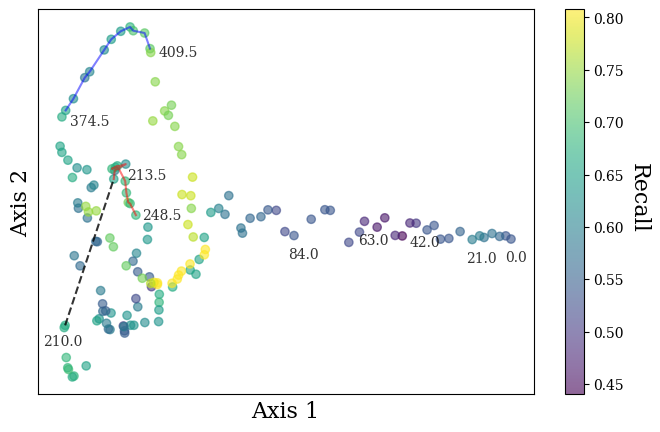

In [51]:
## for rebuttal PDF
idx=5
n_neighbors = 10
n_components = 5
mds = Isomap(n_neighbors=n_neighbors, n_components=n_components, metric='precomputed')
embeddings_lk_L2_match1 = mds.fit_transform(pd1_lk_L2_match_set[idx])
print(mds.kernel_pca_.eigenvalues_)


first, second = 0, 1
embeddings = embeddings_lk_L2_match1
# embeddings = embeddings_lk_L2_match1_spectral
colors = label_traj['rc_old']
plt.figure(figsize=(8,5))
sc = plt.scatter(embeddings[:, first], embeddings[:, second], c=colors, alpha=0.6)
cbar = plt.colorbar(sc)
# cbar.set_label('Recall', rotation=270, fontsize=16, labelpad=2)
ax = cbar.ax
ax.text(3.3,0.6,'Recall',rotation=270, fontsize=16)
# plt.plot(embeddings[:, first], embeddings[:, second], 'g', alpha=0.3)


line_indices = [[i for i in range(61, 72)], [i for i in range(107, 118)]]
# line_indices = [[i for i in range(31, 60)], [i for i in range(61, 90)], [i for i in range(91, 120)]]
# line_indices = [[i for i in range(45, 50)], [i for i in range(78, 83)]]
# line_indices = [[i for i in range(60, 65)], [i for i in range(90, 95)]]
# line_indices = [[i for i in range(51, 60)], [i for i in range(105, 114)], [i for i in range(90, 96)]]
color_set = ['r', 'b', 'm']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.5)    

    
text_indices = [60, 61, 66, 67]
scales = 5
t=60
plt.text(embeddings[t, first]-2.5*scales, embeddings[t, second]-1.3*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=61
plt.text(embeddings[t, first]+1.5*scales, embeddings[t, second]-0.*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=66
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-4*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
# t=67
# plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=71
plt.text(embeddings[t, first]+0.7*scales, embeddings[t, second]-0.3*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=107
plt.text(embeddings[t, first]+0.5*scales, embeddings[t, second]-1*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)
t=117
plt.text(embeddings[t, first]+1*scales, embeddings[t, second]-0.5*scales, f'{t*3.5}', fontsize=10, color='k', alpha=0.8)

line_indices = [[60, 61]]#, [66, 67]]
color_set = ['k--', 'k--']
for i, line_index in enumerate(line_indices):
    plt.plot(embeddings[line_index, first], embeddings[line_index, second], color_set[i], alpha=0.8) 

scales=10
steps=6
for t in range(5):
    
    plt.text(embeddings[steps*t, first]-0.35*scales, embeddings[steps*t, second]-0.75*scales, f'{steps*3.5*t}', fontsize=10, color='k', alpha=0.8)
    
# plt.title('Laplace kernel embedding tau={:.0f}'.format(taus[idx]))
plt.xticks([])
plt.yticks([])    
# plt.xlim([-0.01, 0.005])
# plt.ylim([-0.01, 0.01])
plt.grid()
plt.xlabel('Axis 1', fontsize=16)
plt.ylabel('Axis 2', fontsize=16)
# plt.savefig(f'./spike_embedding_LK1e5.pdf', format='pdf', bbox_inches="tight", dpi=300)
plt.show()

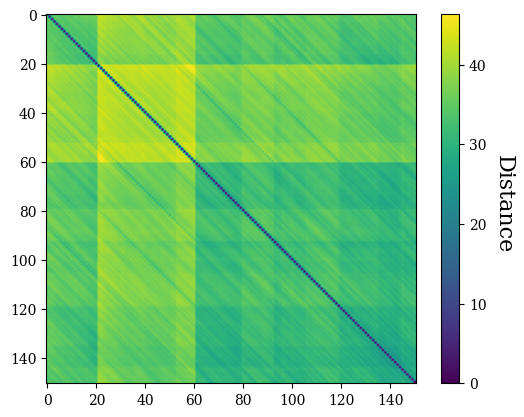

In [52]:
## for rebuttal PDF
idx=3
plt.imshow(pd1_lk_L2_match_set[idx])
plt.colorbar()
# ax = cbar.ax
plt.text(182,95,'Distance',rotation=270, fontsize=16)
# plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))
# plt.savefig(f'./pairwise_dist_LK1e3.pdf', format='pdf', bbox_inches="tight", dpi=300)

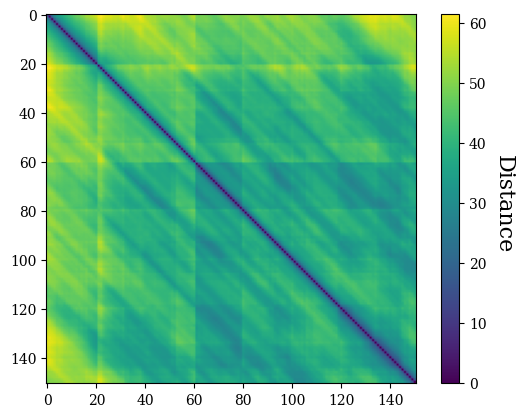

In [53]:
## for rebuttal PDF
idx=4
plt.imshow(pd1_lk_L2_match_set[idx])
plt.colorbar()
# ax = cbar.ax
plt.text(182,95,'Distance',rotation=270, fontsize=16)
# plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))
# plt.savefig(f'./pairwise_dist_LK1e4.pdf', format='pdf', bbox_inches="tight", dpi=300)

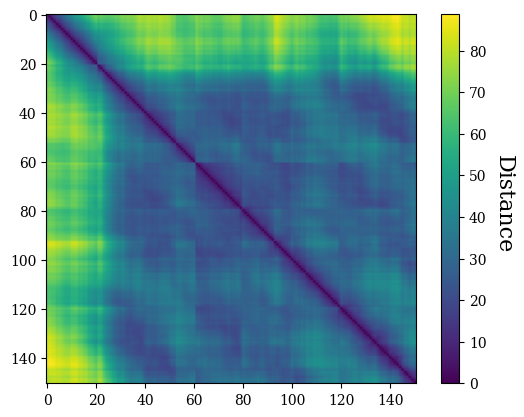

In [54]:
## for rebuttal PDF
idx=5
plt.imshow(pd1_lk_L2_match_set[idx])
plt.colorbar()
# ax = cbar.ax
plt.text(182,95,'Distance',rotation=270, fontsize=16)
# plt.title("Laplace kernel distance tau = {:.1f}".format(taus[idx]))
# plt.savefig(f'./pairwise_dist_LK1e5.pdf', format='pdf', bbox_inches="tight", dpi=300)

In [55]:
def converting_rate_profile(x, w=15000, t=6000, start_time=None):
    # units for x, w, t are miliseconds
    if start_time is None:
        if len(x)>0:
            normalized = x - x[0]
    else:
        normalized = x - start_time
    windows = utils.window_spikes(normalized, w, t, t, binary=True) 
    windows = np.asarray(windows)
    counts = np.sum(windows, axis=-1)
    return counts #- np.mean(counts)

def visualize_firing_rate(indices, X, w, t, binsize = None, ncols=3, figsize=(12,3)):
    # units for X, w, t are miliseconds
    # t: slide size
    # w: window size
    xticks = [0, 35, 70, 105, 140]
    yticks = [range(0,16,5), range(0,5,1), range(0,16,5), range(0,16,5)]
    ylims = [[0,16], [0,5], [0,16],[0,18]]
    moves = [[17,21], [15, 19], [13, 17], [11,15]]
    
    if binsize is None:
        binsize = t
    k = 0
    nrows = (len(indices)-1)//ncols + 1
    for i in range(nrows):
        fig, axes = plt.subplots(nrows=4, ncols=ncols, sharex=True, figsize=figsize, layout='constrained')
        for l in range(ncols):
            for f in range(4):
                if k < len(indices):
                    rate = converting_rate_profile(X[indices[k]][f], w=w, t=binsize, 
                                                           start_time=indices[k]*t)
                    axes[f,l].plot([i*binsize/1000 for i in range(len(rate))], rate, '-', linewidth=1.5, color='blue')
                    # axes[f,l].set_xticks([i for i in range(1, 23, 2)])
                    # axes[f,l].set_xticklabels([], fontsize=12)
                    axes[f,l].set_yticks(yticks[-(f+1)])
                    axes[f,l].set_yticklabels(yticks[-(f+1)], fontsize=8)
                    axes[f,l].set_xticks(xticks)
                    axes[f,l].set_xticklabels(xticks, fontsize=8)
                    #axes[f].set_ylim(ylims[f])
                    axes[f,l].grid(True, linewidth=.5, alpha=0.4, linestyle='--')
                
                    if l == 0:
                        axes[f,l].set_ylabel(f'$k$ = {f+1}')
                    if f == 0:
                        axes[f,l].set_title(f'Window start time: {indices[k]*t/1000} sec')
                    if f == 3:
                        k += 1
                        
                    
                    axes[f,l].axvspan(0, 7, color='gray', alpha=0.5)
                    axes[f,l].axvspan(140-10.5, 140-3.5, color='gray', alpha=0.5)
                        
        fig.supxlabel('Time (sec)', fontsize=16)
        fig.supylabel('Spikes/3.5sec', fontsize=16)
    
    
    #fig.text(0.008, 0.5, 'spike counts', va='center', rotation='vertical', fontsize=10)
    #fig.text(0.92, 0.06, 'time', ha='center', va='center', fontsize=10)
    
    # plt.subplots_adjust(wspace=0, hspace=0.1)
    # plt.suptitle(f'time index: {i}',y=.04, fontsize=12)
    
    
    
    # plt.savefig(f'./fig_spike_{indices[0]}.pdf', format='pdf', bbox_inches="tight", dpi=300)
    plt.show()

[60, 61, 66, 67]


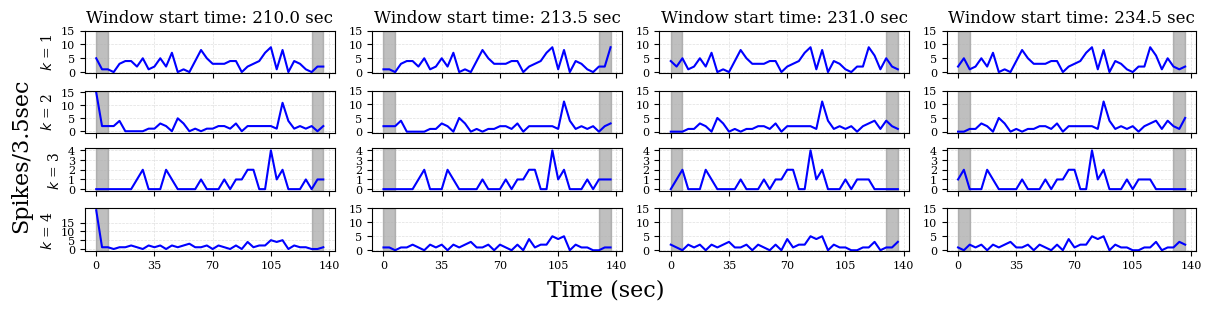

In [56]:
#indices_to_draw = [19,20,21,59,60,61,86,87,88,89,90,91,91,92,93,78,79,80,104,105,106,49,50,51,100,101,102]
# indices_to_draw = [60, 61, 63, 67, 105, 106, 113, 116]
indices_to_draw = [60, 61, 66, 67]
print(indices_to_draw)
t=3500
w=140000
visualize_firing_rate(indices_to_draw, X_new, w, t, binsize=3500, ncols=4)

label_traj = get_count_labels_hist(event_times_normalized_labeled, w/1000, t/1000)

[61, 71, 107, 117]


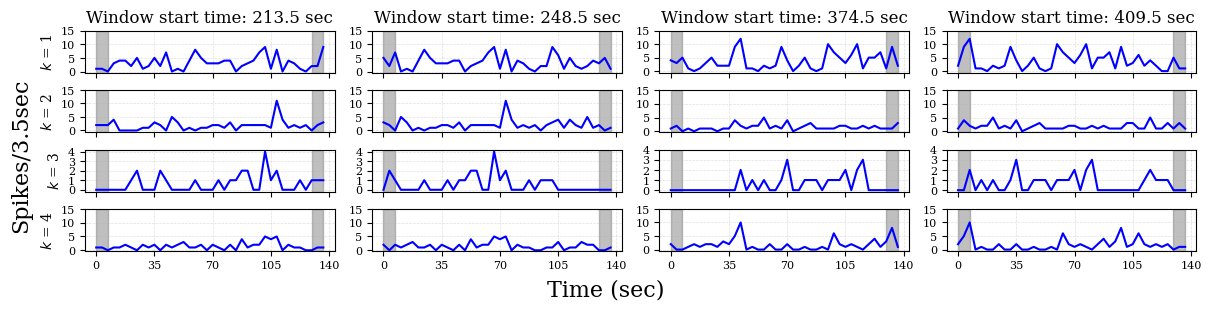

In [57]:
#indices_to_draw = [19,20,21,59,60,61,86,87,88,89,90,91,91,92,93,78,79,80,104,105,106,49,50,51,100,101,102]
# indices_to_draw = [60, 61, 63, 67, 105, 106, 113, 116]
indices_to_draw = [61, 71, 107, 117]
print(indices_to_draw)
t=3500
w=140000
visualize_firing_rate(indices_to_draw, X_new, w, t, binsize=3500, ncols=4)

label_traj = get_count_labels_hist(event_times_normalized_labeled, w/1000, t/1000)